In [2]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import math

In [9]:
def transform(image, show = False):
    kernel = np.ones((2, 2),  np.uint8)
    
    if show:
        fig, axs = plt.subplots(figsize=(16, 4), ncols = 4, nrows = 1)

    im = cv2.resize(image, (200, 200))
    if show:
        axs[0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Исходное изображение')
    
    im = gaussian_filter(im, sigma=0.7)
    if show:
        axs[1].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)) 
        axs[1].set_title('Размытие Гаусса')

    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    if show:
        axs[2].imshow(im, cmap = 'gray' )
        axs[2].set_title('Полутоновое изображение')

    im = cv2.morphologyEx(im,cv2.MORPH_OPEN, kernel, iterations = 2)
    if show:
        axs[3].imshow(im, cmap = 'gray') 
        axs[3].set_title('Эрозия и дилатация')
        for i in range(4):
            axs[i].axis("off")
    
    return im
    

In [10]:
def fun(colors, le):
    avg =[0] * 256
    for k in range(256):
        cnt = 0
        norm = 0

        for l in range(-le // 2, le // 2):
            if 0 <= k + l < 256:
                avg[k] += colors[k + l] * math.exp(- (abs(l) * 2/ le) **2 / 2)
                norm +=  math.exp(- (abs(l) * 2/ le) **2 / 2)
                cnt += 1
        avg[k] /= norm
        
    return avg

In [11]:
def bin_threshold (img, show = False):
    
    color = ['mediumturquoise'] * 256

    if show:
        fig, axs = plt.subplots(figsize=(16, 5), ncols = 2, nrows = 1)
    
    colors = [0] * 256
    for m in range(img.shape[0]):
        for k in range(img.shape[1]):
            colors[img[m, k]] += 1
            
        
    avg = fun(colors, 20)
    avg = fun(avg, 10)
    avg = fun(avg, 15)

    
    
    s = avg / np.max(avg)
    
    pos = 1
    while pos < 256 and s[pos - 1] <= s[pos]:
        pos += 1
    pos += 3
    while pos < 256 and (s[pos - 1] >= s[pos] if s[pos] > 0.5 else  s[pos - 1] >= s[pos] + 1e-4 / 2 * 30): #1e-3 * 2
        pos += 1
               
        
    if show:
        for i in range (pos - 2, pos + 3):
            color[i] = 'red'
            
        axs[0].bar(range(0, 256), colors / np.max(colors), color = color, align='edge') 
        axs[1].bar(range(0, 256), s, align='edge', color = color) 
    
    return colors, s, pos
    
    

In [12]:
def binarization(img, thresh, show = False):
    _, bin_img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
    if show:
        fig, axs = plt.subplots(figsize=(4, 4), ncols = 1, nrows = 1)
        axs.imshow(bin_img, cmap = 'gray')
        axs.axis('off')
    return bin_img

In [13]:
def num_puzzles(img, show = False):
    im = np.zeros_like(img)

    if show:
        fig, axs = plt.subplots(figsize=(4, 4), ncols = 1, nrows = 1)
    areas = []
        
    cntrs, _ = cv2.findContours(img, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
    for cntr in cntrs:
        if cv2.contourArea(cntr) >1/2:
            areas.append(cv2.contourArea(cntr))
            im = cv2.drawContours(im, cntr, -1, 100, 1)
        
    max_area =  np.max(areas)   

    num = 0
    for cntr in cntrs:
        if cv2.contourArea(cntr) / max_area > 0.17:
            im = cv2.drawContours(im, cntr, -1, 255, 1)
            num += 1    
    if show:
        axs.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        axs.axis('off')
        
    return im,  num

In [36]:
def solve(image_name, show = False):

    img = cv2.imread(image_name) 
    image = transform(img, show)
    _, _, thresh = bin_threshold(image, show) 
    binar = binarization(image, thresh, show)
    
    ans = num_puzzles(binar, show)
    
    return cv2.resize(img, (200, 200)), ans[0], ans[1]
    

In [27]:
solve('puzzle_2.jpg')[2]

20

In [28]:
ans = []
ims = []
cntrs = []

vect_images_names = [
    'im.jpg', 'puzzle_1.jpg', 'puzzle_2.jpg', 'Red_3.jpg', 'Red_4.jpg',
    'Motley-1.jpg', 'Motley-2.jpg', 'Motley-3.jpg', 'Motley-4.jpg', 'Motley-5.jpg'
              ]

for v in vect_images_names:
    ims.append(solve(v, False)[0])
    cntrs.append(solve(v, False)[1])
    ans.append(solve(v, False)[2])

In [29]:
ans

[20, 20, 20, 12, 14, 20, 5, 3, 8, 7]

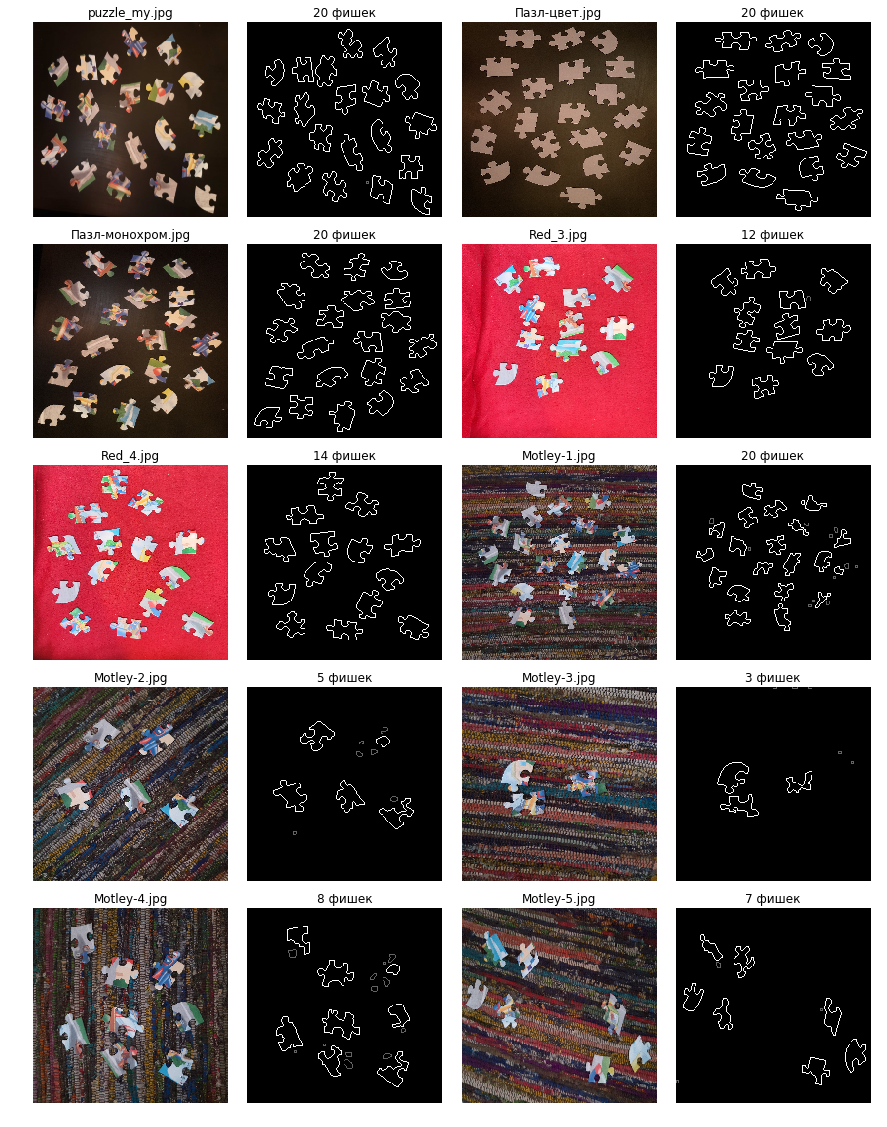

In [30]:
vect_images_names = [
    'puzzle_my.jpg', 'Пазл-цвет.jpg', 'Пазл-монохром.jpg', 'Red_3.jpg', 'Red_4.jpg',
    'Motley-1.jpg', 'Motley-2.jpg', 'Motley-3.jpg', 'Motley-4.jpg', 'Motley-5.jpg'
              ]

fig, axs = plt.subplots(figsize=(15, 20), ncols = 4, nrows = 5)
for i in range(0, 5):
    for j in range(0, 4, 2):
        axs[i, j].imshow(cv2.cvtColor(ims[i*2+j//2], cv2.COLOR_BGR2RGB))
        axs[i, j].set_title(vect_images_names[i*2+j//2])
        axs[i, j + 1].imshow(cntrs[i*2+j//2], cmap = 'gray')
        axs[i, j+1].set_title(str(ans[i*2+j//2]) + ' фишек')

        axs[i, j].axis('off')
        axs[i, j + 1].axis('off')
        fig.subplots_adjust(hspace=0.1, wspace = 0.1) 



In [33]:
true_answers = [20, 20, 20, 12, 14, 20, 5, 3, 8, 7]

In [34]:
np.sum(np.array(ans) == true_answers)

10

7

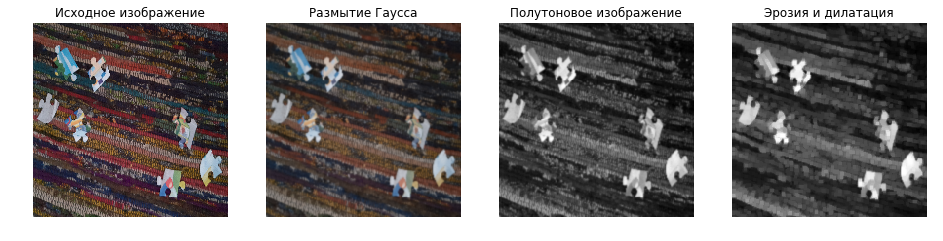

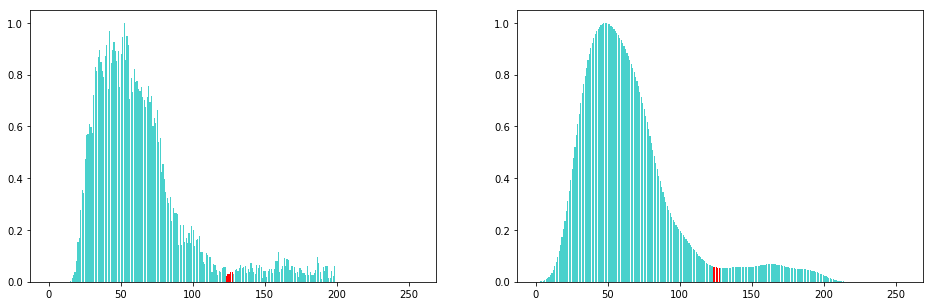

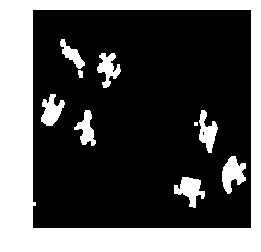

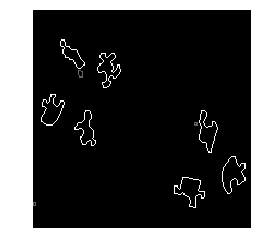

In [37]:
solve('Motley-5.jpg', True)[2]